In [55]:
import pandas as pd
import glob
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["SCIPY_ARRAY_API"] = "1"

In [21]:
def check_array(name, A):
    print(f"{name} shape={A.shape} "
          f"nan={np.isnan(A).sum()} "
          f"posinf={np.isposinf(A).sum()} "
          f"neginf={np.isneginf(A).sum()}")

def smooth_rolling(a, win=3):
    # скользящее среднее по времени, без сдвига длины
    pad = win//2
    ap = np.pad(a, ((0,0),(pad,pad),(0,0)), mode="edge")
    out = np.empty_like(a)
    for t in range(a.shape[1]):
        out[:,t,:] = ap[:,t:t+win,:].mean(axis=1)
    return out


# Загружаем данные и готовим их

In [22]:
# путь к папке
folder = "data"

# ищем все csv-файлы
all_csv = glob.glob(os.path.join(folder, "*.csv"))

# читаем и объединяем
df_0 = pd.concat((pd.read_csv(f) for f in all_csv), ignore_index=True)
print(f"Считано файлов: {len(all_csv)}")

Считано файлов: 4485


In [23]:
df = df_0.drop(columns = ["Lease_Unit"])
print(df.shape)

(1212779, 7)


In [26]:
# переименуем для удобства
df = df.rename(columns={"BBLS_OIL_COND":"oil", "MCF_GAS": 'gas', "BBLS_WTR":"water", "API_WellNo":"well_name", "RptDate":"date", "DAYS_PROD":"days_prod"})
# преобразуем колонку RptDate к datetime
df["date"] = pd.to_datetime(df["date"])
# важно, чтобы внутри каждой скважины ряды шли строго по времени
df = df.sort_values(by=["well_name", "date"]).reset_index(drop=True)

In [29]:
# Рассмотрим начальные данные
df.describe()

,date,oil,gas,water,DAYS_PROD
count,1212779,1.212779e+06,1.212779e+06,1.212779e+06,1.212766e+06
mean,2007-11-21 05:52:21.935999744,2.183546e+02,5.578952e+02,1.551285e+03,1.938541e+01
min,1986-01-31 00:00:00,-4.020000e+02,-1.990000e+02,-5.150000e+02,-1.000000e+00
25%,1999-06-30 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008-09-30 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01
75%,2016-09-30 00:00:00,7.500000e+01,3.730000e+02,2.000000e+02,3.100000e+01
max,2025-08-31 00:00:00,4.401900e+04,2.119520e+05,5.519390e+05,3.310000e+03
std,NaN,7.803683e+02,2.841415e+03,7.551180e+03,2.523993e+01


In [30]:
# Есть записи с отрицательными дебитами. Исключим их, так как работа будет вестись только с добывающими скважинами
df = df[(df['oil'] >= 0) & (df['gas'] >= 0) & (df['water'] >= 0)]

In [31]:
# какие интервалы времени?
df.groupby("well_name")["date"].diff().value_counts().head()

date
31 days    635132
30 days    363685
0 days     113109
28 days     68846
29 days     23433
Name: count, dtype: int64

In [32]:
# ресемплинг
df = (
    df.set_index("date")
      .groupby("well_name")
      .resample("M").sum(numeric_only=True)
      .reset_index()
)

/var/folders/vz/15qxg5jx3cv1s2r8qgnsl8zr0000gn/T/ipykernel_66967/2920662743.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M").sum(numeric_only=True)
/var/folders/vz/15qxg5jx3cv1s2r8qgnsl8zr0000gn/T/ipykernel_66967/2920662743.py:5: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .resample("M").sum(numeric_only=True)


In [33]:
# датасет без NaN
df[['oil', 'gas', 'water']].isna().sum()

oil      0
gas      0
water    0
dtype: int64

In [34]:
# производные каналы
df['wct'] = df['oil'] / (df['oil'] + df['water'] + 1e-9)
df['gor'] = df['gas'] / df['oil']

# ограничим wc от 0 до 1
df["wct"] = df["wct"].clip(0,1)

# заполним NaN gor нулями
df["gor"] = df["gor"].fillna(0)

In [35]:
# дата запуска скважины
# для manifold сравнивать скважины корректнее не по календарным датам, а от момента запуска
first_prod = (
    df.loc[df["oil"] > 0, ["well_name", "date"]]
      .groupby("well_name", as_index=False)["date"].min()
      .rename(columns={"date": "first_date"})
)

# мерджим
df = df.merge(first_prod, on="well_name", how="left")
# если у скважины вообще нет oil>0, first_date будет NaT — такие строки лучше отбросить
df = df[~df["first_date"].isna()].copy()

# считаем целые месяцы от старта добычи
df["t_months"] = (
    (df["date"].dt.year - df["first_date"].dt.year) * 12
    + (df["date"].dt.month - df["first_date"].dt.month)
).astype(int)

# оставляем только месяцы с t_months >= 0 (в данных есть записи до запуска)
df = df[df["t_months"] >= 0].copy()


In [36]:
df.describe()

/Users/george/Documents/ML изучение/ds_learning/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,date,oil,gas,water,DAYS_PROD,wct,gor,first_date,t_months
count,669913,669913.000000,669913.000000,669913.000000,669913.000000,669913.000000,6.699130e+05,669913,669913.000000
mean,2006-11-04 11:32:18.389611776,395.279786,413.879892,2534.306707,20.586039,0.295512,inf,1990-12-16 03:04:47.075485568,190.657899
min,1986-01-31 00:00:00,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000e+00,1986-01-31 00:00:00,0.000000
25%,1997-01-31 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1986-01-31 00:00:00,79.000000
50%,2007-07-31 00:00:00,35.000000,0.000000,18.000000,29.000000,0.053109,0.000000e+00,1986-01-31 00:00:00,169.000000
75%,2016-07-31 00:00:00,359.000000,90.000000,898.000000,31.000000,0.592937,2.358491e-01,1991-09-30 00:00:00,291.000000
max,2025-08-31 00:00:00,68646.000000,250328.000000,597308.000000,6030.000000,1.000000,inf,2025-07-31 00:00:00,475.000000
std,NaN,1100.677067,3495.653759,10230.845840,33.432933,0.381095,NaN,NaN,131.044320


In [37]:
df.dtypes

well_name             object
date          datetime64[ns]
oil                    int64
gas                    int64
water                  int64
DAYS_PROD            float64
wct                  float64
gor                  float64
first_date    datetime64[ns]
t_months               int64
dtype: object

In [38]:
df

,well_name,date,oil,gas,water,DAYS_PROD,wct,gor,first_date,t_months
386,25-003-05007-00-00,1986-01-31,252,0,2552,31.0,0.089872,0.000000,1986-01-31,0
387,25-003-05007-00-00,1986-02-28,239,0,2295,28.0,0.094317,0.000000,1986-01-31,1
388,25-003-05007-00-00,1986-03-31,253,0,2697,31.0,0.085763,0.000000,1986-01-31,2
389,25-003-05007-00-00,1986-04-30,249,0,1883,30.0,0.116792,0.000000,1986-01-31,3
390,25-003-05007-00-00,1986-05-31,278,0,2631,31.0,0.095565,0.000000,1986-01-31,4
...,...,...,...,...,...,...,...,...,...,...
1130342,25-111-21271-00-00,2025-03-31,0,0,0,0.0,0.000000,0.000000,2013-02-28,145
1130343,25-111-21271-00-00,2025-04-30,0,0,0,0.0,0.000000,0.000000,2013-02-28,146
1130344,25-111-21271-00-00,2025-05-31,60,16,5505,16.0,0.010782,0.266667,2013-02-28,147
1130345,25-111-21271-00-00,2025-06-30,0,0,0,0.0,0.000000,0.000000,2013-02-28,148


# Анализ профилей

## Шаг 1. Быстрые проверки качества
Сколько точек на скважину в окне? Например, T = 36 мес

Убираем скважины с очень короткой историей (скажем, < 6 точек)

Есть ли полностью нулевые ряды? Убираем

Доля нулевых месяцев (shut-in, то есть скважины заглушены): считаем как признак, но для сравнения форм он не должен доминировать

In [39]:
T = 36
g = df[df["t_months"]<=T].groupby("well_name")
cnt = g.size()
valid_wells = cnt[cnt >= 6].index
df = df[df["well_name"].isin(valid_wells)].copy()

## Шаг 2. Собираем «куб» данных для manifold

Зачем: большинство алгоритмов ожидают одинаковую длину ряда. Мы сформируем массив формы
[n_wells, T+1, C], где каналы C = {oil, wc, gor}

пивот по t_months → строки — скважины, столбцы — время.

Заполняем отсутствующие месяцы нулями (считаем, что нет добычи).

Приводим каналы к одному масштабу: нормируем oil на пик (для «формы»), а WC и GOR и так масштабированы (WC∈[0,1]; GOR можно лог-трансформировать при желании).

In [40]:
channels = ["oil", "wct", "gor"]

# pivot для каждого канала
mats = []
well_index = None
for ch in channels:
    mat = (
        df[df["t_months"]<=T]
        .pivot_table(index="well_name", columns="t_months", values=ch, aggfunc="sum")
        .reindex(columns=range(T+1))  # гарантируем 0..T
        .fillna(0.0)
        .sort_index()
    )
    if well_index is None:
        well_index = mat.index
    else:
        mat = mat.loc[well_index]
    mats.append(mat.values[:, :, None])  # [n_wells, T+1, 1]

X = np.concatenate(mats, axis=2)  # [n_wells, T+1, C]
wells = well_index.to_numpy()

# нормировка oil на пик по каждому ряду (избегаем деления на 0)
oil = X[:,:,channels.index("oil")]
peak = np.maximum(oil.max(axis=1, keepdims=True), 1e-9)
X[:,:,channels.index("oil")] = oil / peak

# WC в [0,1] уже ок; GOR опционально можно "подсжать": gor' = log1p(gor) / max
if "gor" in channels:
    gor = X[:,:,channels.index("gor")]
    gor = np.log1p(gor)
    gmax = np.maximum(gor.max(axis=1, keepdims=True), 1e-9)
    X[:,:,channels.index("gor")] = gor / gmax


/var/folders/vz/15qxg5jx3cv1s2r8qgnsl8zr0000gn/T/ipykernel_66967/3345480539.py:33: RuntimeWarning: invalid value encountered in divide
  X[:,:,channels.index("gor")] = gor / gmax


In [41]:
X_s = smooth_rolling(X, win=3)
X_s = np.nan_to_num(X_s, nan=0.0, posinf=0.0, neginf=0.0)

## первый manifold-прототип
начнём максимально просто и быстро:

Метрика: DTW (динамическое выравнивание) по канально-взвешенной сумме.

Эмбеддинг: UMAP (или PHATE/Diffusion Maps; начнём с UMAP из-за удобства).

Кластеризация: HDBSCAN (не требует заранее k и устойчив к шуму).

In [42]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# ---------- утилиты ----------
def smooth_rolling(a, win=3):
    """Скользящее среднее по времени (по каждой скважине и каналу)."""
    if win <= 1:
        return a
    pad = win // 2
    ap = np.pad(a, ((0,0), (pad,pad), (0,0)), mode="edge")
    out = np.empty_like(a)
    for t in range(a.shape[1]):
        out[:, t, :] = ap[:, t:t+win, :].mean(axis=1)
    return out

def build_cube(df, channels=("oil","wc"), T=100, smooth_win=3):
    """
    Из long-таблицы df -> тензор X: [n_wells, T+1, C] + список wells.
    Требования к df: колонки [well_name, t_months, oil, water, gas, wc, gor].
    """
    # соберём по каналам матрицы [n_wells, T+1]
    mats = []
    well_index = None
    for ch in channels:
        mat = (
            df[df["t_months"] <= T]
            .pivot_table(index="well_name", columns="t_months", values=ch, aggfunc="sum")
            .reindex(columns=range(T+1))
            .fillna(0.0)
            .sort_index()
        )
        if well_index is None:
            well_index = mat.index
        else:
            mat = mat.loc[well_index]
        mats.append(mat.values[:, :, None])  # [n, T+1, 1]
    X = np.concatenate(mats, axis=2)  # [n, T+1, C]
    wells = well_index.to_numpy()

    # нормировка для "формы"
    if "oil" in channels:
        oil_idx = channels.index("oil")
        oil = X[:, :, oil_idx]
        peak = np.maximum(oil.max(axis=1, keepdims=True), 1e-9)
        X[:, :, oil_idx] = oil / peak

    if "gor" in channels:
        gor_idx = channels.index("gor")
        gor = np.log1p(np.maximum(X[:, :, gor_idx], 0.0))
        gmax = np.maximum(gor.max(axis=1, keepdims=True), 1e-9)
        X[:, :, gor_idx] = gor / gmax

    # лёгкое сглаживание (помогает UMAP/DTW)
    X = smooth_rolling(X, win=smooth_win)

    # санация на всякий случай
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    return X, wells

def series_from_cube(X, weights=None):
    """
    Свести многоканал в один сигнал формы: взвешенная сумма по каналам.
    X: [n, T+1, C]; weights длины C. По умолчанию oil важнее.
    """
    n, L, C = X.shape
    if weights is None:
        # oil=1.0, wc=0.7, gor=0.3 (обрежется по числу каналов)
        default = np.array([1.0, 0.7, 0.3])
        weights = default[:C]
    w = weights / weights.sum()
    sig = (X * w[None, None, :]).sum(axis=2)  # [n, T+1]
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    return sig

def cdist_fastdtw(S, radius=5, n_jobs=-1):
    """
    Парная матрица расстояний fastdtw (аппроксимация DTW).
    Гарантируем 1-D входы для fastdtw (ravel) и избегаем scipy.euclidean.
    """
    try:
        from fastdtw import fastdtw
    except ImportError:
        raise ImportError("Установите fastdtw: pip install fastdtw")

    # страховки формы/типов
    if not isinstance(S, np.ndarray):
        S = np.asarray(S)
    assert S.ndim == 2, f"S must be 2-D, got shape {S.shape}"
    S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0).astype(float, copy=False)

    n = S.shape[0]
    D = np.zeros((n, n), dtype=float)

    def row(i):
        di = np.zeros(n, dtype=float)
        si = np.asarray(S[i]).ravel()  # гарантированно 1-D
        for j in range(i + 1, n):
            sj = np.asarray(S[j]).ravel()  # гарантированно 1-D
            d, _ = fastdtw(si, sj, radius=radius)  # без scipy.euclidean
            di[j] = d
        return i, di
    
    from joblib import Parallel, delayed
    results = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(row)(i) for i in range(n))
    for i, di in results:
        D[i, :] = di
    D = D + D.T
    return D

def build_embedding_fastdtw(
    df,
    channels=("oil","wc"),
    T=100,
    sample_size=1200,
    random_state=42,
    fastdtw_radius=5,
    n_neighbors=30,
    min_dist=0.05,
    min_cluster_size=40,
    min_samples=10,
    smooth_win=3
):
    """
    Главная функция:
    1) df -> X (куб), затем сводим к сигналам S
    2) считаем попарные fastdtw расстояния на подвыборке
    3) UMAP (metric=precomputed) -> Z
    4) HDBSCAN -> labels
    Возвращает: Z, labels, wells_used, D
    """
    # 1) тензор профилей
    X, wells_all = build_cube(df, channels=channels, T=T, smooth_win=smooth_win)
    S_all = series_from_cube(X)

    # 2) подвыборка (для скорости). Позже можно убрать, чтобы взять все скважины.
    rng = np.random.default_rng(random_state)
    n = S_all.shape[0]
    if sample_size is None or sample_size >= n:
        idx = np.arange(n)
    else:
        idx = rng.choice(n, size=sample_size, replace=False)
    S = S_all[idx]
    wells_used = wells_all[idx]

    # безопасность:
    S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
    assert np.isfinite(S).all(), "В S остались не-финитные значения"

    # 3) попарные расстояния fastdtw
    D = cdist_fastdtw(S, radius=fastdtw_radius, n_jobs=-1)

    # 4) UMAP по матрице расстояний
    import umap
    um = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="precomputed",
        random_state=random_state,
    )
    Z = um.fit_transform(D)

    # 5) HDBSCAN на эмбеддинге
    import hdbscan
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples
    )
    labels = clusterer.fit_predict(Z)

    return Z, labels, wells_used, D


/Users/george/Documents/ML изучение/ds_learning/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/george/Documents/ML изучение/ds_learning/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/george/Documents/ML изучение/ds_learning/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/george/Documents/ML изучение/ds_learning/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


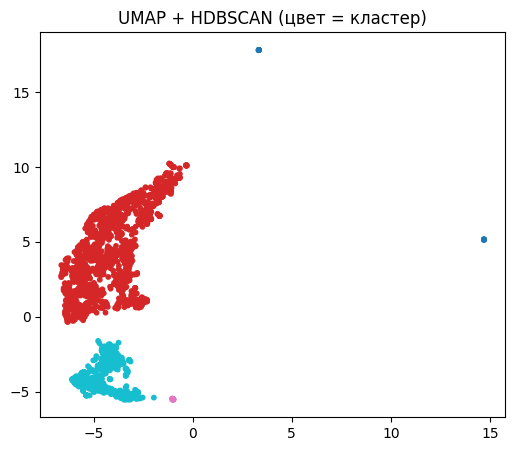

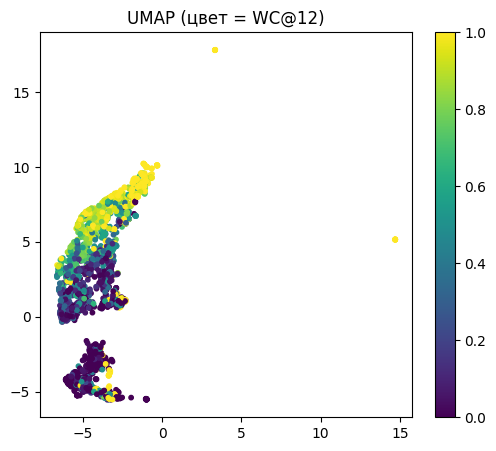

In [43]:
# Параметры
T = 36
channels = ("oil","wct")  # начнём без GOR; потом можно добавить "gor"
Z, labels, wells_used, D = build_embedding_fastdtw(
    df,
    channels=channels,
    T=T,
    sample_size=4100,       # подвыборка для скорости (можно 800–1500)
    fastdtw_radius=6,       # 5–10 обычно норм
    n_neighbors=30,
    min_dist=0.05,
    min_cluster_size=20,
    min_samples=10,
    smooth_win=3,
    random_state=42
)

# Визуализация и первичная интерпретация
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=labels, s=10, cmap="tab10")
plt.title("UMAP + HDBSCAN (цвет = кластер)")
plt.show()

# Раскрасим по WC@12, чтобы понять физику осей
wc12 = (
    df[df["t_months"]==12]
    .set_index("well_name")["wct"]
    .reindex(wells_used).to_numpy()
)

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=wc12, s=10)
plt.title("UMAP (цвет = WC@12)")
plt.colorbar()
plt.show()


In [44]:
# === 1) СВОДКА ПО КЛАСТЕРАМ ===
import pandas as pd
import numpy as np

def cluster_summary(df, wells_used, labels, extra=False):
    """
    df: long-таблица с колонками [well_name, t_months, oil, water, gas, wc, gor]
    wells_used: np.array имен скважин из эмбеддинга/кластеризации
    labels: кластеры HDBSCAN для wells_used
    extra: если True, досчитаем cum_oil_36, wc@24, t_to_peak (дороже)
    """
    res = []
    wells_used = np.asarray(wells_used)

    # предрасчёты для скорости
    sub = df[df["well_name"].isin(wells_used)].copy()

    # wc@12
    wc12 = (sub[sub["t_months"]==12]
            .groupby("well_name")["wct"].mean())

    # cum_oil_24
    cum24 = (sub[sub["t_months"]<=24]
             .groupby("well_name")["oil"].sum())

    if extra:
        wc24 = (sub[sub["t_months"]==24]
                .groupby("well_name")["wct"].mean())
        cum36 = (sub[sub["t_months"]<=36]
                 .groupby("well_name")["oil"].sum())
        # t_to_peak: первый месяц максимума oil
        ttp = (sub.groupby("well_name")
                  .apply(lambda g: int(g.loc[g["oil"].idxmax()]["t_months"])
                         if len(g)>0 else np.nan))

    for c in sorted(set(labels)):
        if c == -1:
            # Шум/аномалии вынесем в отдельную строку
            mask = labels == -1
            wells_c = wells_used[mask]
            if len(wells_c)==0:
                continue
            res.append({
                "cluster": -1,
                "n_wells": int(len(wells_c)),
                "wc12_median": float(wc12.reindex(wells_c).median()),
                "cum24_median": float(cum24.reindex(wells_c).median()),
                **({"wc24_median": float(wc24.reindex(wells_c).median())} if extra else {}),
                **({"cum36_median": float(cum36.reindex(wells_c).median())} if extra else {}),
                **({"t_to_peak_median": float(ttp.reindex(wells_c).median())} if extra else {}),
            })
            continue

        wells_c = wells_used[labels==c]
        res.append({
            "cluster": int(c),
            "n_wells": int(len(wells_c)),
            "wc12_median": float(wc12.reindex(wells_c).median()),
            "cum24_median": float(cum24.reindex(wells_c).median()),
            **({"wc24_median": float(wc24.reindex(wells_c).median())} if extra else {}),
            **({"cum36_median": float(cum36.reindex(wells_c).median())} if extra else {}),
            **({"t_to_peak_median": float(ttp.reindex(wells_c).median())} if extra else {}),
        })

    summary = pd.DataFrame(res).sort_values(["cluster","n_wells"]).sort_values("n_wells", ascending=False)
    return summary


# === 2) МЕДОИДЫ КЛАСТЕРОВ (типичные скважины) ===
from joblib import Parallel, delayed

def pick_cluster_medoids(df, wells_used, labels, channels=("oil","wct"),
                         T=100, fastdtw_radius=6, max_wells_per_cluster=300,
                         random_state=42):
    """
    Возвращает dict: {cluster_id: {"medoid_well": str, "wells": np.array([...])}}
    Считает попарные расстояния fastdtw внутри кластера и выбирает медоид
    (ряд с минимальной суммой расстояний). Если кластер слишком большой,
    используем случайную подвыборку до max_wells_per_cluster.
    """
    # используем ваши функции build_cube/series_from_cube из предыдущих шагов
    X, wells_all = build_cube(df, channels=channels, T=T, smooth_win=3)
    S_all = series_from_cube(X)  # [n, T+1]

    # сопоставление имя -> индекс в S_all
    well_to_idx = {w:i for i,w in enumerate(wells_all)}

    rng = np.random.default_rng(random_state)
    medoids = {}

    def cdist_fastdtw_local(S, radius=6):
        try:
            from fastdtw import fastdtw
        except ImportError:
            raise ImportError("pip install fastdtw")
        n = S.shape[0]
        D = np.zeros((n, n), dtype=float)

        def row(i):
            di = np.zeros(n, dtype=float)
            si = np.asarray(S[i]).ravel()
            for j in range(i+1, n):
                sj = np.asarray(S[j]).ravel()
                d, _ = fastdtw(si, sj, radius=radius)
                di[j] = d
            return i, di

        results = Parallel(n_jobs=-1, prefer="threads")(delayed(row)(i) for i in range(n))
        for i, di in results:
            D[i, :] = di
        D = D + D.T
        return D

    for c in sorted(set(labels)):
        if c == -1:
            continue
        wells_c = wells_used[labels==c]
        if len(wells_c)==0:
            continue

        # подвыборка при необходимости (для скорости)
        if len(wells_c) > max_wells_per_cluster:
            wells_c = rng.choice(wells_c, size=max_wells_per_cluster, replace=False)

        idxs = [well_to_idx[w] for w in wells_c if w in well_to_idx]
        S = S_all[idxs]

        # матрица попарных расстояний внутри кластера
        Dcl = cdist_fastdtw_local(S, radius=fastdtw_radius)

        # медоид = индекс с минимальной суммой расстояний
        medoid_local_idx = Dcl.sum(axis=1).argmin()
        medoid_well = wells_c[medoid_local_idx]

        medoids[int(c)] = {"medoid_well": medoid_well, "wells": np.array(wells_c)}

    return medoids


# === 3) ВИЗУАЛИЗАЦИЯ ПРОТОТИПОВ ===
import matplotlib.pyplot as plt

def plot_cluster_prototypes(df, medoids, T=100):
    """
    Рисует для каждого кластера 2 графика медоида:
    (а) oil (нормированный на пик) и (б) WC.
    """
    for c, info in medoids.items():
        w = info["medoid_well"]
        g = df[(df["well_name"]==w) & (df["t_months"]<=T)].sort_values("t_months")
        if g.empty:
            continue

        # oil нормировка на пик (для формы)
        oil = g["oil"].to_numpy().astype(float)
        peak = max(oil.max(), 1e-9)
        oil_n = oil / peak

        wc = g["wct"].to_numpy().astype(float)
        t = g["t_months"].to_numpy().astype(int)

        fig, axes = plt.subplots(1, 2, figsize=(10,3))
        axes[0].plot(t, oil_n, marker="o", linewidth=1)
        axes[0].set_title(f"Cluster {c}: {w}\nOil (norm by peak)")
        axes[0].set_xlabel("t_months"); axes[0].set_ylabel("oil (norm)"); axes[0].grid(True, alpha=0.3)

        axes[1].plot(t, wc, marker="o", linewidth=1)
        axes[1].set_title(f"Cluster {c}: {w}\nWater cut")
        axes[1].set_xlabel("t_months"); axes[1].set_ylabel("WC"); axes[1].set_ylim(0,1); axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


/var/folders/vz/15qxg5jx3cv1s2r8qgnsl8zr0000gn/T/ipykernel_66967/2369007916.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: int(g.loc[g["oil"].idxmax()]["t_months"])


,cluster,n_wells,wc12_median,cum24_median,wc24_median,cum36_median,t_to_peak_median
1,0,1623,0.5,18047.0,0.5,25097.0,9.0
3,2,558,0.0,677.5,0.0,746.0,3.0
2,1,26,0.0,13.5,0.0,13.5,0.0
0,-1,20,1.0,873.5,1.0,1033.0,56.0


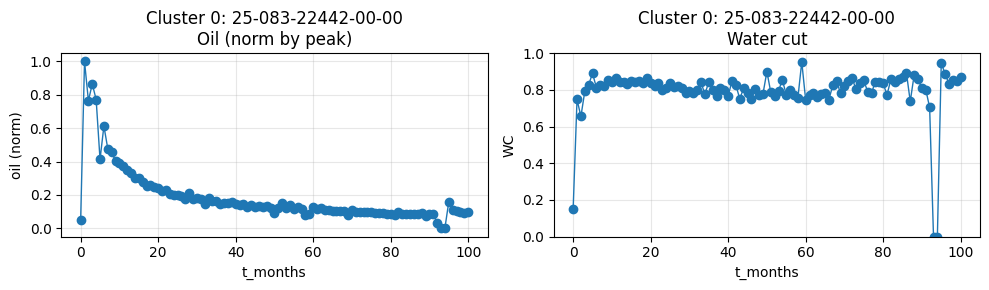

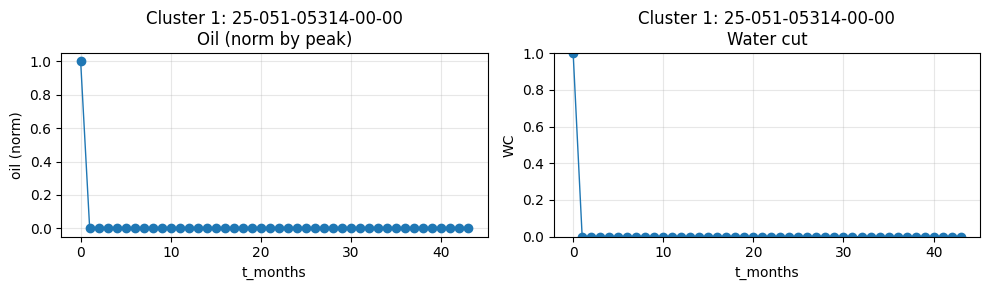

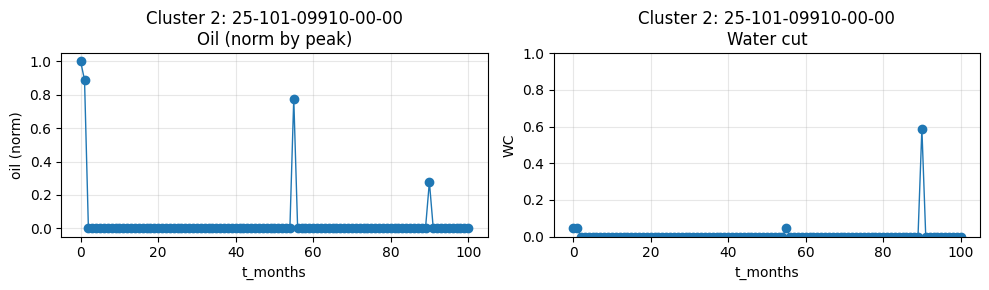

In [45]:
# 1) Сводка
summary = cluster_summary(df, wells_used, labels, extra=True)
display(summary)

# 2) Медоиды
medoids = pick_cluster_medoids(
    df, wells_used, labels,
    channels=("oil","wct"),   # те же каналы, что использовали в эмбеддинге
    T=100,
    fastdtw_radius=6,
    max_wells_per_cluster=300
)

# 3) Графики прототипов
plot_cluster_prototypes(df, medoids, T=100)
